In [147]:
import pandas as pd
import seaborn as sns
import re
import time
import numpy as np

from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud, STOPWORDS 

In [37]:
# notification
from subprocess import call

def notify(content=""):
    cmd = 'display notification \"' + \
        "Your training is done! Time: "+content + '\" with title \"Jupyter-notebook\"'
    call(["osascript", "-e", cmd])

In [110]:
df1 = pd.read_csv('../data/train.csv')
df2 = pd.read_csv('../data/dev.csv')

In [9]:
df1

,ex_id,user_id,prod_id,rating,label,date,review
0,0,923,0,3.0,1,2014-12-08,The food at snack is a selection of popular Gr...
1,1,924,0,3.0,1,2013-05-16,This little place in Soho is wonderful. I had ...
2,2,925,0,4.0,1,2013-07-01,ordered lunch for 15 from Snack last Friday. ...
3,3,926,0,4.0,1,2011-07-28,This is a beautiful quaint little restaurant o...
4,4,927,0,4.0,1,2010-11-01,Snack is great place for a casual sit down lu...
...,...,...,...,...,...,...,...
250869,358950,14671,349,5.0,0,2014-02-08,Made a reservation for an early dinner Saturda...
250870,358951,3356,349,5.0,0,2014-02-07,"Emily is like Franny's Marco, but with warmth ..."
250871,358953,116424,349,5.0,0,2014-01-31,Can't say enough good things about this place....
250872,358954,161147,349,5.0,0,2014-01-30,"Had a great dinner here- fantastic pizza, the ..."


In [21]:
df1.label.shape

(250874,)

In [11]:
df2

,ex_id,user_id,prod_id,rating,label,date,review
0,11,934,0,5.0,1,2014-01-20,"all around good place, cozy, I came in and did..."
1,17,940,0,4.0,0,2014-09-16,"For lunch, my friend and I had: -Lamb sandwich..."
2,20,943,0,5.0,0,2014-05-24,Some good Big Greek cooking!! Came to City on ...
3,30,953,0,4.0,0,2013-10-17,So... as you may notice from some of my other ...
4,43,966,0,3.0,0,2012-12-19,"I don't understand the whole ""You can't order ..."
...,...,...,...,...,...,...,...
35913,358855,161115,349,3.0,0,2014-12-15,"Okay, so I gotta repeat the chorus here and st..."
35914,358859,161116,349,2.0,0,2014-12-10,"The pizza is delicious, but it's SO loud here,..."
35915,358884,161125,349,5.0,0,2014-09-05,Emily has hands down the best pizza I've had i...
35916,358894,1423,349,5.0,0,2014-07-13,I'm not entirely sure who came up with the nam...


In [117]:
df_all=pd.concat([df1,df2],axis=0)
df_all

,ex_id,user_id,prod_id,rating,label,date,review
0,0,923,0,3.0,1,2014-12-08,The food at snack is a selection of popular Gr...
1,1,924,0,3.0,1,2013-05-16,This little place in Soho is wonderful. I had ...
2,2,925,0,4.0,1,2013-07-01,ordered lunch for 15 from Snack last Friday. ...
3,3,926,0,4.0,1,2011-07-28,This is a beautiful quaint little restaurant o...
4,4,927,0,4.0,1,2010-11-01,Snack is great place for a casual sit down lu...
...,...,...,...,...,...,...,...
35913,358855,161115,349,3.0,-1,2014-12-15,"Okay, so I gotta repeat the chorus here and st..."
35914,358859,161116,349,2.0,-1,2014-12-10,"The pizza is delicious, but it's SO loud here,..."
35915,358884,161125,349,5.0,-1,2014-09-05,Emily has hands down the best pizza I've had i...
35916,358894,1423,349,5.0,-1,2014-07-13,I'm not entirely sure who came up with the nam...


In [113]:
# normalize label
df1.label=df1.label.replace(0,-1)
df2.label=df2.label.replace(0,-1)
df2.label

0        1
1       -1
2       -1
3       -1
4       -1
        ..
35913   -1
35914   -1
35915   -1
35916   -1
35917   -1
Name: label, Length: 35918, dtype: int64

In [155]:
# resampling for balanced dataset
print(df1['label'].value_counts())
print(df1['label'].value_counts(1))
n_neg,n_pos=df1['label'].value_counts()

df1_neg=df1.loc[df1['label'] == -1]
df1_pos=df1.loc[df1['label'] == 1]

# downsampling
df1_neg_sample=df1_neg.sample(n=n_pos)
df1_downsample=pd.concat([df1_neg_sample,df1_pos],axis=0)

# upsampling
df1_pos_dup=df1_pos
for i in range(n_neg//n_pos-1):
    df1_pos_dup=pd.concat([df1_pos,df1_pos_dup],axis=0)
df1_upsample=pd.concat([df1_neg,df1_pos_dup],axis=0)

# randomize
sampler = np.random.permutation(df1_downsample.shape[0])
df1_downsample=df1_downsample.take(sampler)

sampler = np.random.permutation(df1_upsample.shape[0])
df1_upsample=df1_upsample.take(sampler)
df1_upsample

-1    225055
 1     25819
Name: label, dtype: int64
-1    0.897084
 1    0.102916
Name: label, dtype: float64


,ex_id,user_id,prod_id,rating,label,date,review
27963,39927,31106,95,5.0,-1,2014-08-30,There is nothing negative that I can write abo...
27746,39624,1121,93,4.0,-1,2006-01-16,A fave of the locals. Excellent french inspir...
62576,89326,58739,903,2.0,-1,2013-07-30,"Can't figure out what's worse, the food, the s..."
201109,287696,99113,755,4.0,-1,2013-08-12,This tiny hidden place definitely lives up to ...
59178,84522,56479,243,5.0,1,2011-12-20,Had an amazing experience here with my friends...
...,...,...,...,...,...,...,...
174688,249937,126573,656,5.0,1,2010-09-03,This place is awesome. I feel right at home wh...
17275,24589,20589,72,5.0,1,2013-02-10,Delicious!! Well worth the wait!!
76967,110115,68784,312,3.0,1,2012-03-07,"Maybe because I was expecting too much, and he..."
132031,188775,32525,515,4.0,-1,2014-06-09,I rolled in here out of whim for late lunch (4...


In [145]:
df1_sample.shape[0]

51638

In [62]:
# stopwords from nltk
stopwords1=set(stopwords.words('english'))|set([''])
# stopwords from wordcloud
stopwords2 = set(STOPWORDS)
add_stopword=set(['','aren', 'couldn', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'isn', 'let', 'll', 'mustn', 're', 'shan', 'shouldn', 've', 'wasn', 'weren', 'won', 'wouldn'])
stopwords2=stopwords2|add_stopword

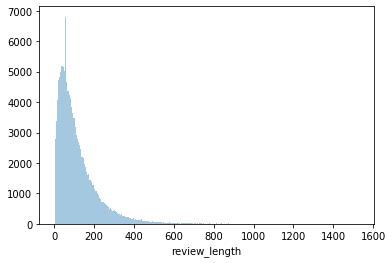

In [56]:
# statistics
df1['review_length'] = df1['review'].apply(lambda x: len(x.split()))
df1['review_length_nonstopwords'] = df1['review'].apply(
    lambda x: len([word for word in (re.sub(r'[^\w]', ' ', x)).lower().split() if word not in stopwords]))
sns.distplot(df1['review_length'], kde=False, bins=500)

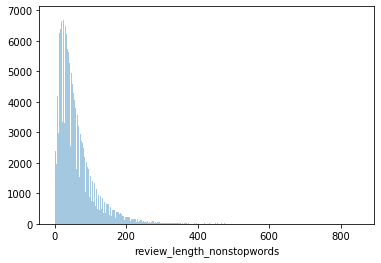

In [57]:
sns.distplot(df1['review_length_nonstopwords'], kde=False, bins=500)

In [40]:
# text preprocessing
def preprocessing(df):
    texts=[]
    chars=re.compile(r'[0-9]+')
    symbols = '${}()[].,:;+-*/&|<>=~"\'@#$%^`~!?_'
    for k, v in df.review.items():
        v=chars.sub('', v)
        v = v.split(' ')
        words = map(lambda Element: Element.translate(str.maketrans("", "", symbols)).strip().lower(), v)
        v=' '.join(words).strip()
        texts.append(v)
    return texts

In [120]:
review_train=preprocessing(df1)

In [156]:
review_train_downsample=preprocessing(df1_downsample)

In [157]:
review_train_upsample=preprocessing(df1_upsample)

In [46]:
for v in review_train[:3]:
    print(v)
    for i in range(10):
        if str(i) in v:
            print('has number')

the food at snack is a selection of popular greek dishes the appetizer tray is good as is the greek salad we were underwhelmed with the main courses there are  tables here so its sometimes hard to get seated
this little place in soho is wonderful i had a lamb sandwich and a glass of wine the price shocked me for how small the serving was but then again this is soho the staff can be a little snotty and rude but the food is great just dont expect worldclass service
ordered lunch for  from snack last friday on time nothing missing and the food was great i have added it to the regular company lunch list as everyone enjoyed their meal


In [128]:
# get features from the whole training set
vectorizer_train=TfidfVectorizer(stop_words=stopwords1,ngram_range=(1,2),min_df=30) # max_features=100 (top 100 features)
review_vec_train = vectorizer_train.fit_transform(review_train)
notify()

In [132]:
print(review_vec_train.shape)
print(vectorizer_train.get_feature_names()[:50])

(250874, 71069)
['aaron', 'aback', 'abalone', 'abandon', 'abandoned', 'abc', 'abc carpet', 'abc home', 'abc kitchen', 'abeille', 'ability', 'abit', 'abita', 'able', 'able accommodate', 'able bring', 'able catch', 'able choose', 'able come', 'able eat', 'able enjoy', 'able find', 'able finish', 'able get', 'able give', 'able go', 'able grab', 'able handle', 'able hear', 'able hold', 'able keep', 'able make', 'able move', 'able order', 'able pick', 'able put', 'able sample', 'able say', 'able score', 'able seat', 'able seated', 'able see', 'able share', 'able sit', 'able snag', 'able squeeze', 'able take', 'able talk', 'able taste', 'able tell']


In [158]:
# get feature vectors for the sampled training set 
vectorizer_train_sample=TfidfVectorizer(vocabulary=vectorizer_train.get_feature_names(),stop_words=stopwords1,ngram_range=(1,2),min_df=30) # max_features=100 (top 100 features)
review_vec_train_downsample = vectorizer_train_sample.fit_transform(review_train_downsample)
review_vec_train_upsample = vectorizer_train_sample.fit_transform(review_train_upsample)
notify()

In [161]:
print(vectorizer_train_sample.get_feature_names()[:50])
print(review_vec_train_downsample.shape)
print(review_vec_train_upsample.shape)

['aaron', 'aback', 'abalone', 'abandon', 'abandoned', 'abc', 'abc carpet', 'abc home', 'abc kitchen', 'abeille', 'ability', 'abit', 'abita', 'able', 'able accommodate', 'able bring', 'able catch', 'able choose', 'able come', 'able eat', 'able enjoy', 'able find', 'able finish', 'able get', 'able give', 'able go', 'able grab', 'able handle', 'able hear', 'able hold', 'able keep', 'able make', 'able move', 'able order', 'able pick', 'able put', 'able sample', 'able say', 'able score', 'able seat', 'able seated', 'able see', 'able share', 'able sit', 'able snag', 'able squeeze', 'able take', 'able talk', 'able taste', 'able tell']
(51638, 71069)
(431607, 71069)


In [67]:
# get feature vectors for the test set
review_test=preprocessing(df2)
vectorizer_test=TfidfVectorizer(vocabulary=vectorizer_train.get_feature_names(),stop_words=stopwords1,ngram_range=(1,2),min_df=30) 
review_vec_test = vectorizer_test.fit_transform(review_test)
notify()

In [68]:
print(review_vec_test.shape)
print(vectorizer_train.get_feature_names()[:50])

(35918, 71069)
['aaron', 'aback', 'abalone', 'abandon', 'abandoned', 'abc', 'abc carpet', 'abc home', 'abc kitchen', 'abeille', 'ability', 'abit', 'abita', 'able', 'able accommodate', 'able bring', 'able catch', 'able choose', 'able come', 'able eat', 'able enjoy', 'able find', 'able finish', 'able get', 'able give', 'able go', 'able grab', 'able handle', 'able hear', 'able hold', 'able keep', 'able make', 'able move', 'able order', 'able pick', 'able put', 'able sample', 'able say', 'able score', 'able seat', 'able seated', 'able see', 'able share', 'able sit', 'able snag', 'able squeeze', 'able take', 'able talk', 'able taste', 'able tell']


In [143]:
# train: unbalanced
X_train=review_vec_train
y_train=df1.label
clf=MultinomialNB(alpha=0.01)
clf.fit(X_train, y_train)

X_test=review_vec_test
y_test=df2.label
predicted = clf.predict(X_test)
print(metrics.classification_report(y_test, predicted))

print('parameters:\n',clf.get_params())
print('predict probablity:\n',clf.predict_proba(X_test))

              precision    recall  f1-score   support

          -1       0.90      1.00      0.95     32270
           1       0.35      0.01      0.02      3648

    accuracy                           0.90     35918
   macro avg       0.63      0.50      0.48     35918
weighted avg       0.84      0.90      0.85     35918

parameters:
 {'alpha': 0.01, 'class_prior': None, 'fit_prior': True}
predict probablity:
 [[0.91862945 0.08137055]
 [0.98654879 0.01345121]
 [0.95371636 0.04628364]
 ...
 [0.92906278 0.07093722]
 [0.99572847 0.00427153]
 [0.99494146 0.00505854]]


In [142]:
# train: balanced, downsampling
X_train=review_vec_train_downsample
y_train=df1_downsample.label
clf=MultinomialNB(alpha=0.01)
clf.fit(X_train, y_train)

X_test=review_vec_test
y_test=df2.label
predicted = clf.predict(X_test)
print(metrics.classification_report(y_test, predicted))

print('parameters:\n',clf.get_params())
print('predict probablity:\n',clf.predict_proba(X_test))

              precision    recall  f1-score   support

          -1       0.94      0.67      0.78     32270
           1       0.18      0.63      0.27      3648

    accuracy                           0.66     35918
   macro avg       0.56      0.65      0.53     35918
weighted avg       0.86      0.66      0.73     35918

parameters:
 {'alpha': 0.01, 'class_prior': None, 'fit_prior': True}
predict probablity:
 [[0.30791473 0.69208527]
 [0.84833024 0.15166976]
 [0.63150663 0.36849337]
 ...
 [0.49303751 0.50696249]
 [0.95271484 0.04728516]
 [0.8800837  0.1199163 ]]


In [162]:
# train: balanced, upsampling
X_train=review_vec_train_upsample
y_train=df1_upsample.label
clf=MultinomialNB(alpha=0.01)
clf.fit(X_train, y_train)

X_test=review_vec_test
y_test=df2.label
predicted = clf.predict(X_test)
print(metrics.classification_report(y_test, predicted))

print('parameters:\n',clf.get_params())
print('predict probablity:\n',clf.predict_proba(X_test))

              precision    recall  f1-score   support

          -1       0.93      0.75      0.83     32270
           1       0.20      0.53      0.29      3648

    accuracy                           0.73     35918
   macro avg       0.57      0.64      0.56     35918
weighted avg       0.86      0.73      0.78     35918

parameters:
 {'alpha': 0.01, 'class_prior': None, 'fit_prior': True}
predict probablity:
 [[0.57791822 0.42208178]
 [0.89903052 0.10096948]
 [0.71155456 0.28844544]
 ...
 [0.61344254 0.38655746]
 [0.98388243 0.01611757]
 [0.97733962 0.02266038]]
